In [80]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
import deeptime.markov as markov
from deeptime.plots import plot_implied_timescales
from deeptime.util.validation import implied_timescales
import pyemma
plt.style.use('/localscratch/zippoema/md_plots/corr_plot.mplstyle')

# Create MSM discrete trajectory

In [37]:
def changes_to_phosphostate(changes, boolstart=0, step=10000, end_time=3000000000, save=None):
    """
    Determines the phospho-state of a system over time based on recorded changes.

    Args:
        changes (ndarray): A numpy array where the first column contains time steps at which 
                           phosphorylation state changes occur.
        boolstart (int, optional): Initial phospho-state (0 for unphosphorylated, 1 for phosphorylated). 
                                   Defaults to 0.
        step (int, optional): Time step interval to evaluate the phospho-state (usually equal to dump time step). Defaults to 10000.
        end_time (int, optional): Maximum simulation time. Defaults to 3000000000.

    Returns:
        ndarray: An array where each element represents the phospho-state at each step.
    """
    phosphobool = []  # List to hold phospho-state at each time step
    index = 0         # Index to track position in `changes`
    
    # Calculate initial state based on changes within the first step
    ch_count = np.sum(changes[index:, 0] <= step)  # Count changes up to `step`
    phosphobool.append(int(not boolstart) if ch_count % 2 else boolstart)
    index += ch_count

    # Iterate through time steps and compute phospho-state
    for t in range(1, int(end_time / step)):
        ch_count = np.sum(changes[index:, 0] <= (t + 1) * step)  # Count changes up to the next step
        if ch_count % 2:
            # Toggle the previous state if an odd number of changes occurred
            phosphobool.append(int(not phosphobool[-1]))
        else:
            # Keep the previous state if changes are even
            phosphobool.append(phosphobool[-1])
        index += ch_count  # Update index to skip counted changes

    if save is not None:
        np.savetxt(save, phosphobool)
    else:
        return np.array(phosphobool)

In [28]:
def create_states_trajectory(boundtraj, phosphotraj, save=None):
    """
    Generates a state trajectory based on phosphorylation and binding states.
    The state values are:
                 - 1: Unphosphorylated and unbound.
                 - 2: Unphosphorylated and bound.
                 - 3: Phosphorylated and bound.
                 - 4: Phosphorylated and unbound.

    Args:
        boundtraj (ndarray): Boolean array where each element represents the binding state 
                             at a given time step (True for bound, False for unbound).
        phosphotraj (ndarray): Boolean array where each element represents the phosphorylation state 
                               at a given time step (True for phosphorylated, False for unphosphorylated).
        save (str, optional): File path to save the state trajectory as a text file. If None, returns 
                              the state array. Defaults to None.

    Returns:
        ndarray: An array representing the state trajectory at each time step if `save` is None.
                 
    """
    # Initialize the state array with zeros
    states = np.zeros(len(phosphotraj), dtype=int)

    # Define states based on phosphorylation and binding trajectories
    states[~phosphotraj & ~boundtraj] = 1  # Unphosphorylated and unbound
    states[~phosphotraj & boundtraj] = 2   # Unphosphorylated and bound
    states[phosphotraj & boundtraj] = 3    # Phosphorylated and bound
    states[phosphotraj & ~boundtraj] = 4   # Phosphorylated and unbound

    # Save the state trajectory to file if 'save' is provided, otherwise return the array
    if save is not None:
        np.savetxt(save, states, fmt='%d')  # Save as integer values
    else:
        return states

In [24]:
path_ness=f"/localscratch/zippoema/md_data/simple-ness/sim_ser{n_ser}/"

In [34]:
# Select NESS simulation
n_ser = 10
dmu = -5

changes = np.loadtxt(path_ness+f"sim-ser{n_ser}_mu{dmu}_ck1d-rigid_tdp43_changes.txt")
print(n_ser, dmu)
phospho_bool = changes_to_phosphostate(changes, end_time=2000000000).astype(bool)

10 -5


In [43]:
bound_bool = np.loadtxt(path_ness+f"sim-ser{n_ser}_mu{dmu}_ck1d-rigid_tdp43_boundtraj.txt").astype(bool)

states = create_states_trajectory(~bound_bool, phospho_bool[5000:], save=None)

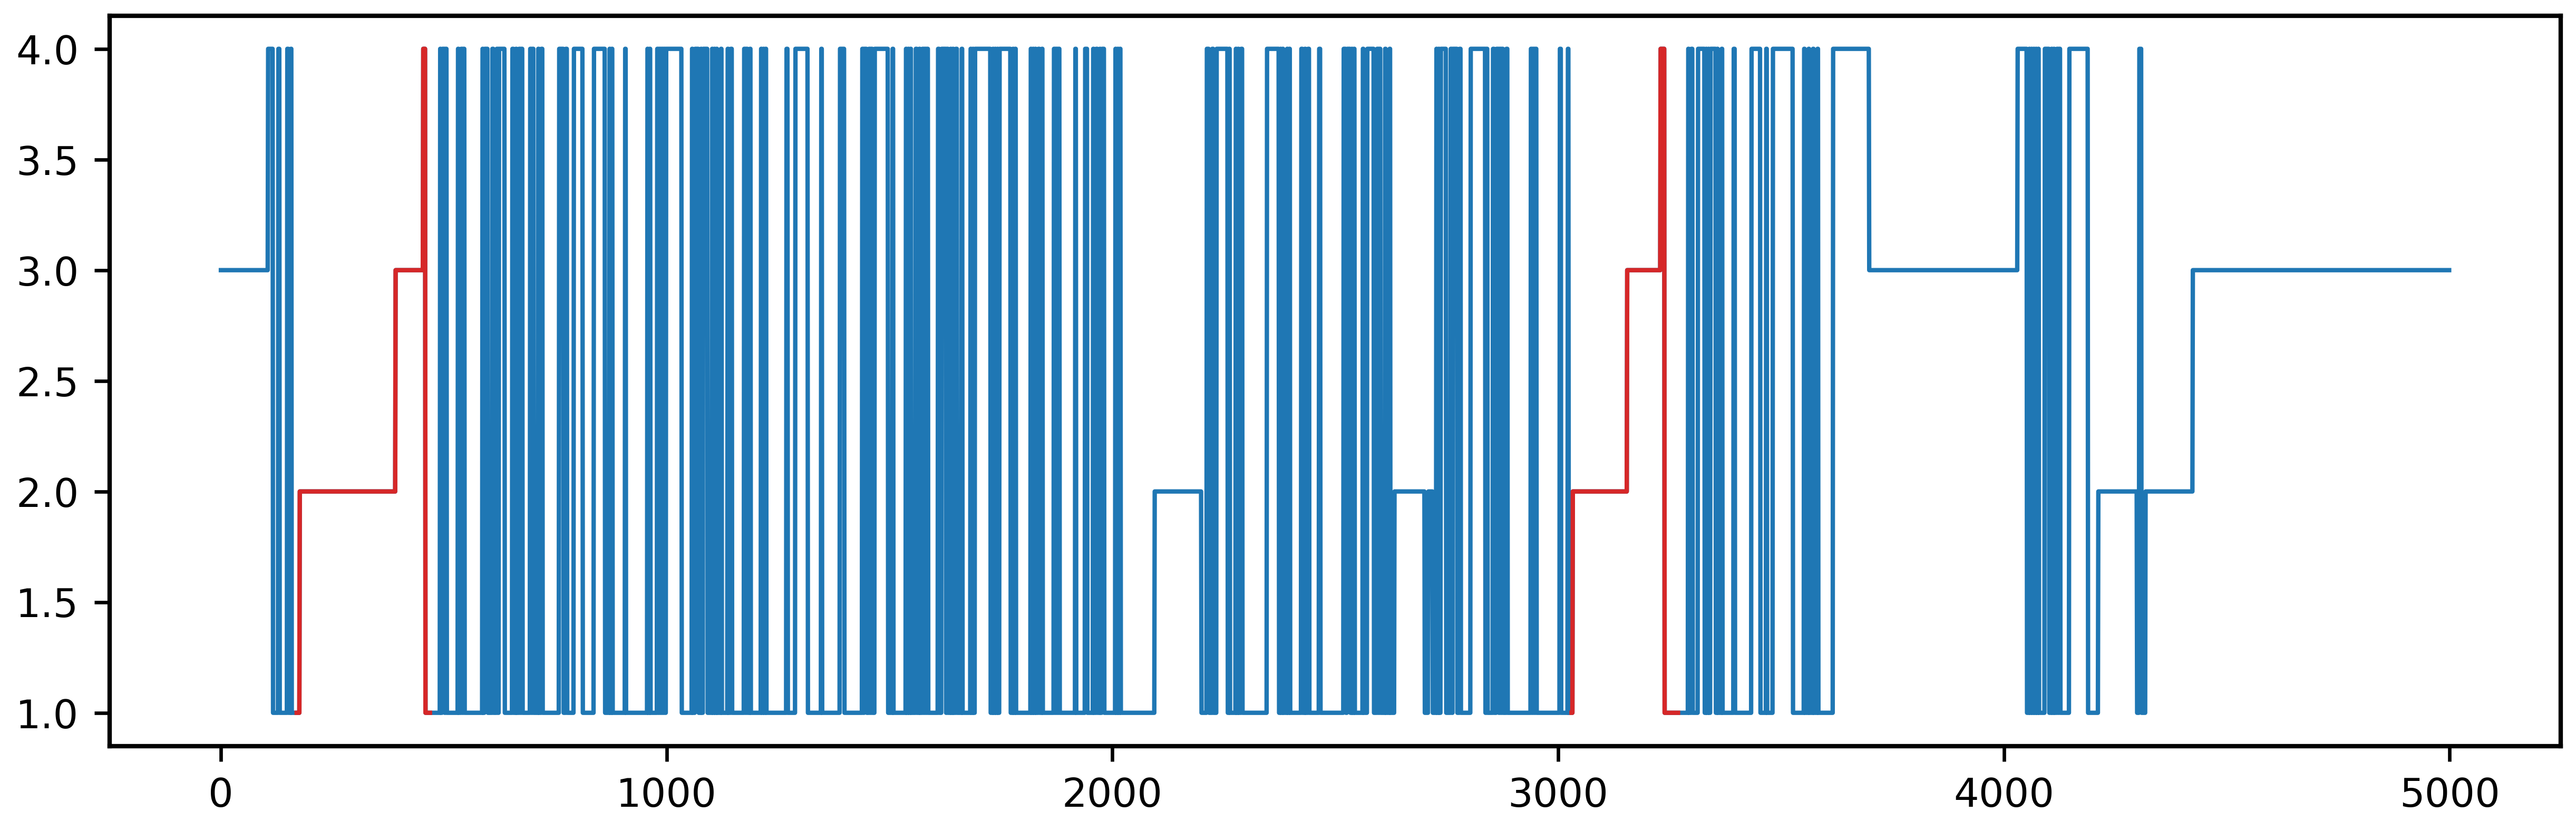

In [56]:
plt.figure(figsize=(10,3))
plt.plot(states[0:5000], color='tab:blue')
plt.plot(np.arange(170,470), states[170:470], color='tab:red')
plt.plot(np.arange(3030,3270), states[3030:3270], color='tab:red')


# Compute rates MSM

In [71]:
models = []
lagtimes = [1,10,20,40,70]
for lagtime in lagtimes:
    counts = markov.TransitionCountEstimator(lagtime=lagtime, count_mode='effective').fit_fetch(states-1)
    models.append(markov.msm.BayesianMSM(n_samples=100, n_steps=10, reversible=False).fit_fetch(counts))

### Implied timescales

Text(0, 0.5, 'timescale (steps)')

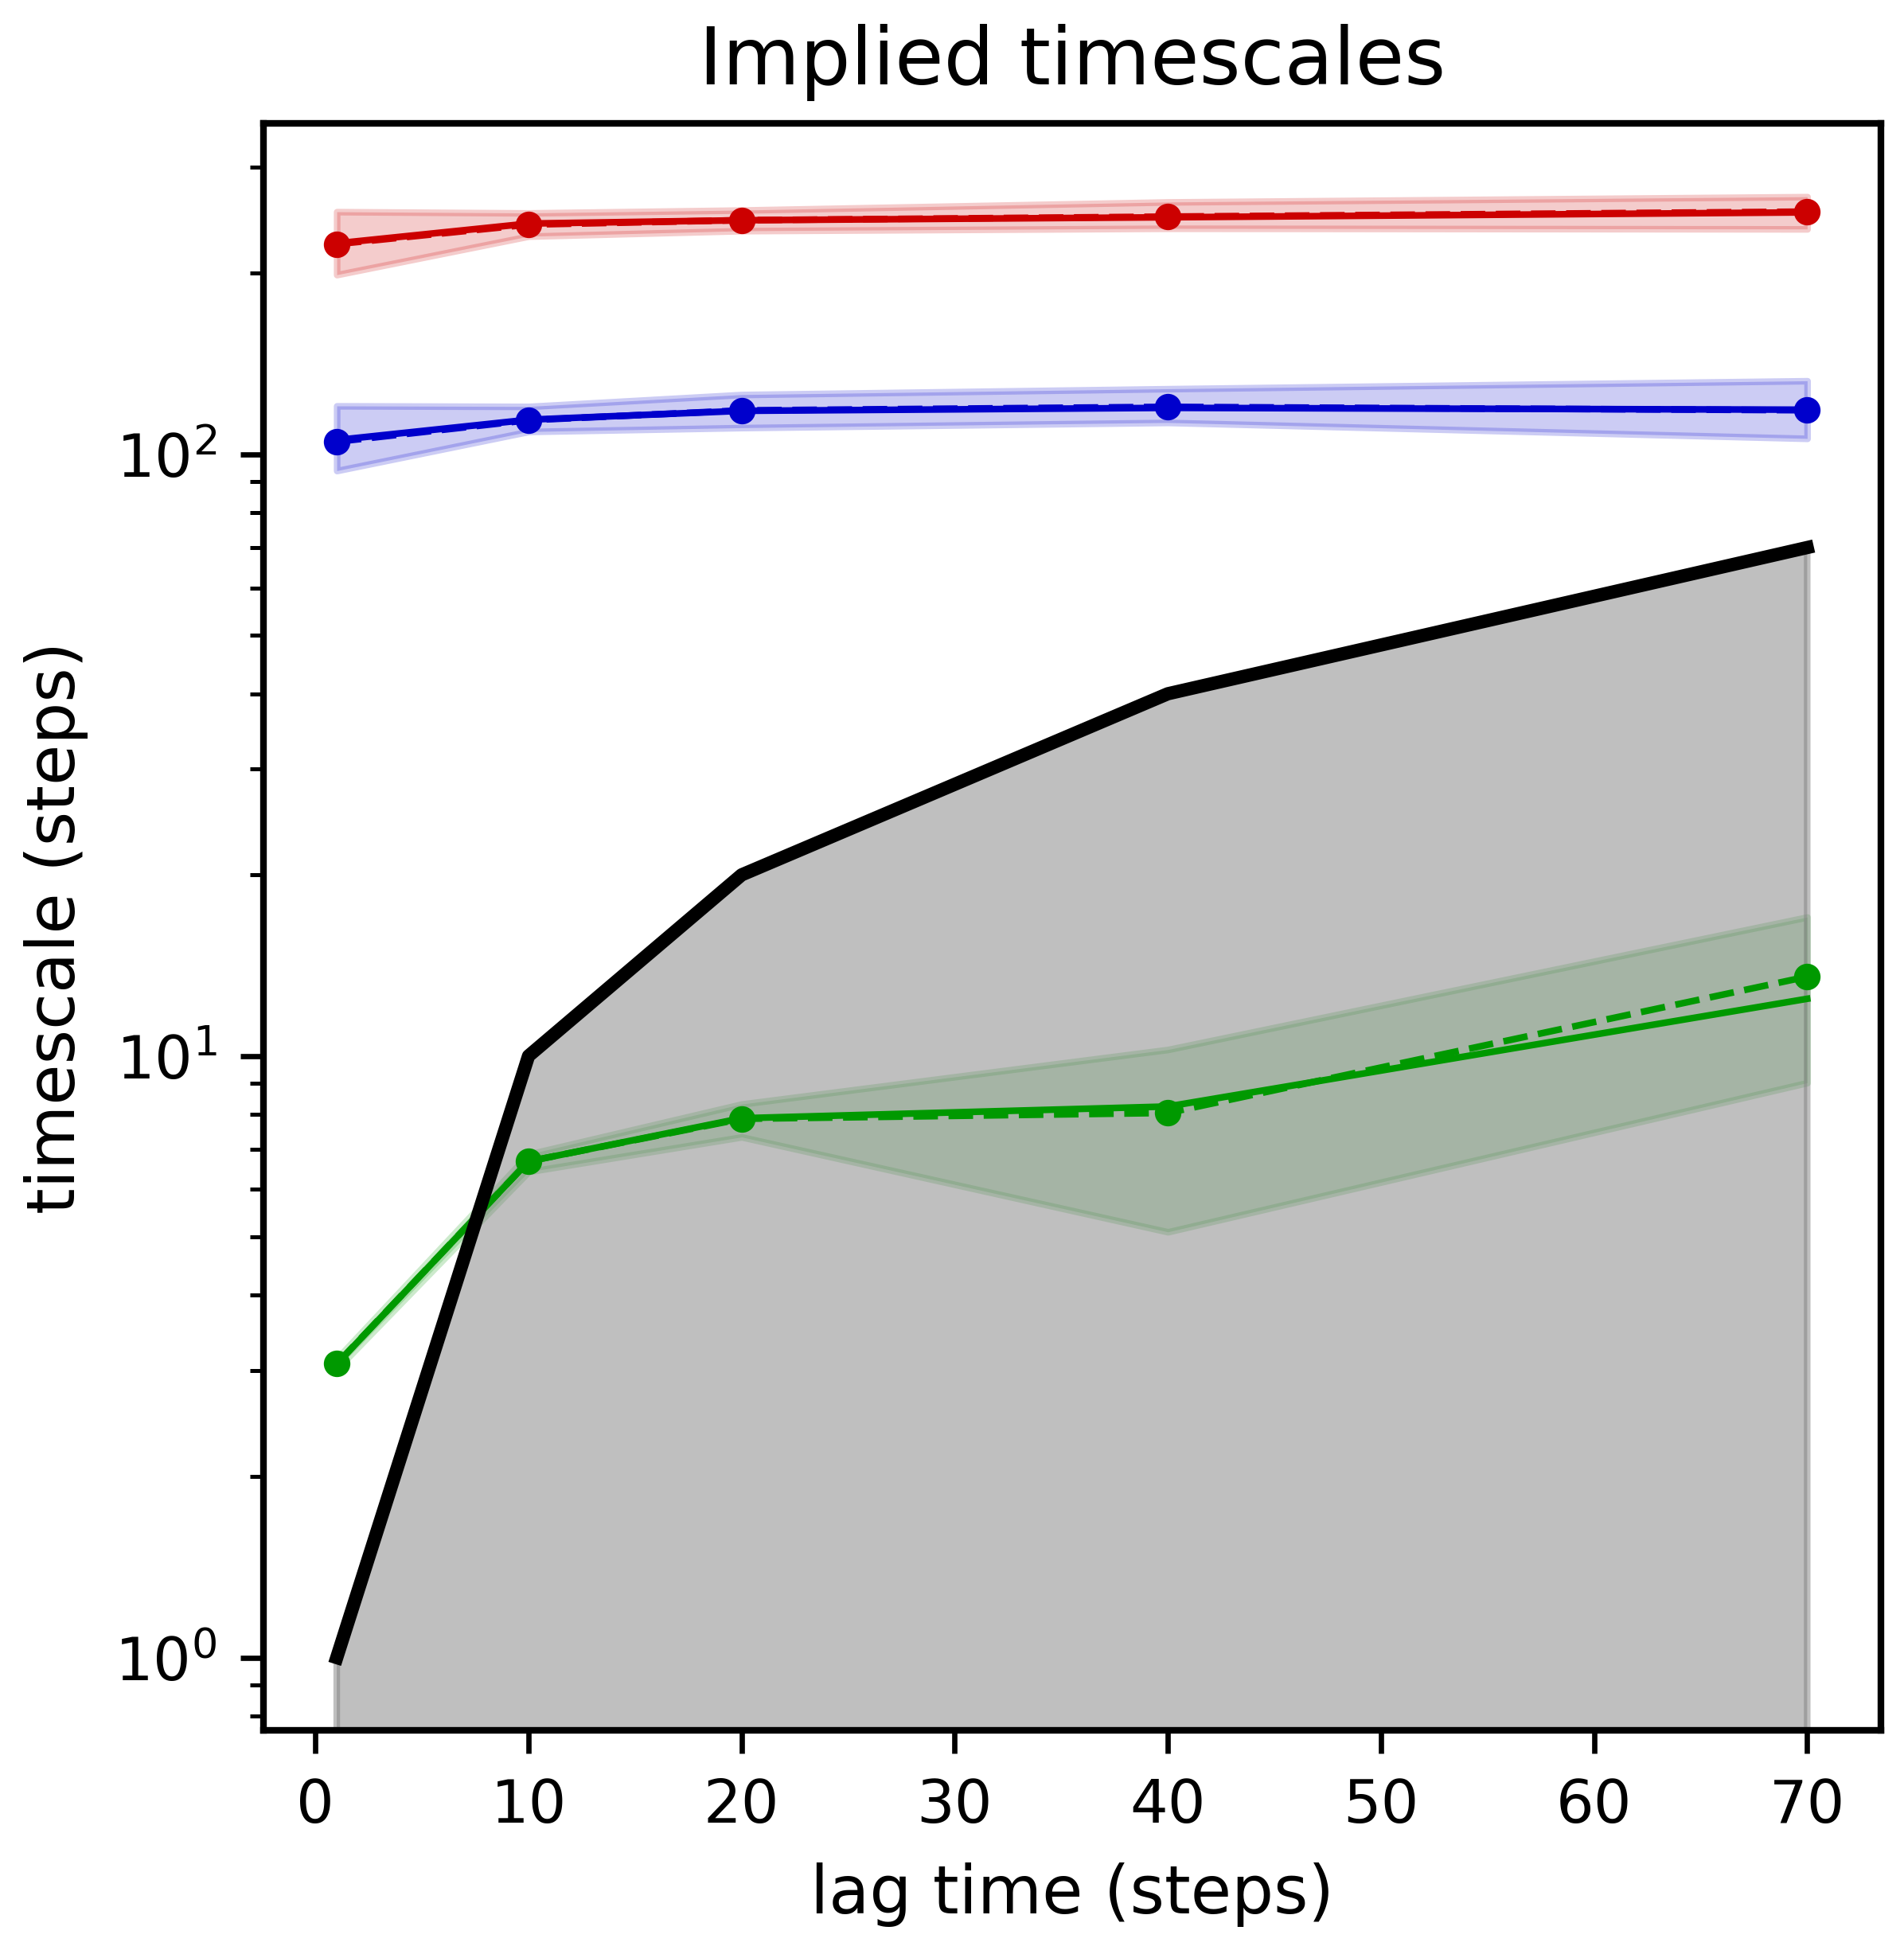

In [76]:
its_data = implied_timescales(models)

fig, ax = plt.subplots(1, 1)
plot_implied_timescales(its_data, ax=ax)
ax.set_yscale('log')
ax.set_title('Implied timescales')
ax.set_xlabel('lag time (steps)')
ax.set_ylabel('timescale (steps)')

In [81]:
# model with lagtime 10
msm = pyemma.msm.bayesian_markov_model(states, lag=10, reversible=False)


100%|██████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1159.80it/s]


### Chapman-Kolmogorov test

In [82]:
# ck test for 3 state msm (state 1 and 4 are the same)
ck3 = msm.cktest(3, memberships=np.array([[1,0,0],[0,1,0],[0,0,1],[1,0,0]]))

# ck test for 3 state msm
ck4 = msm.cktest(4, memberships=np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]]))

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:17<00:00,  1.91s/it]


Plots

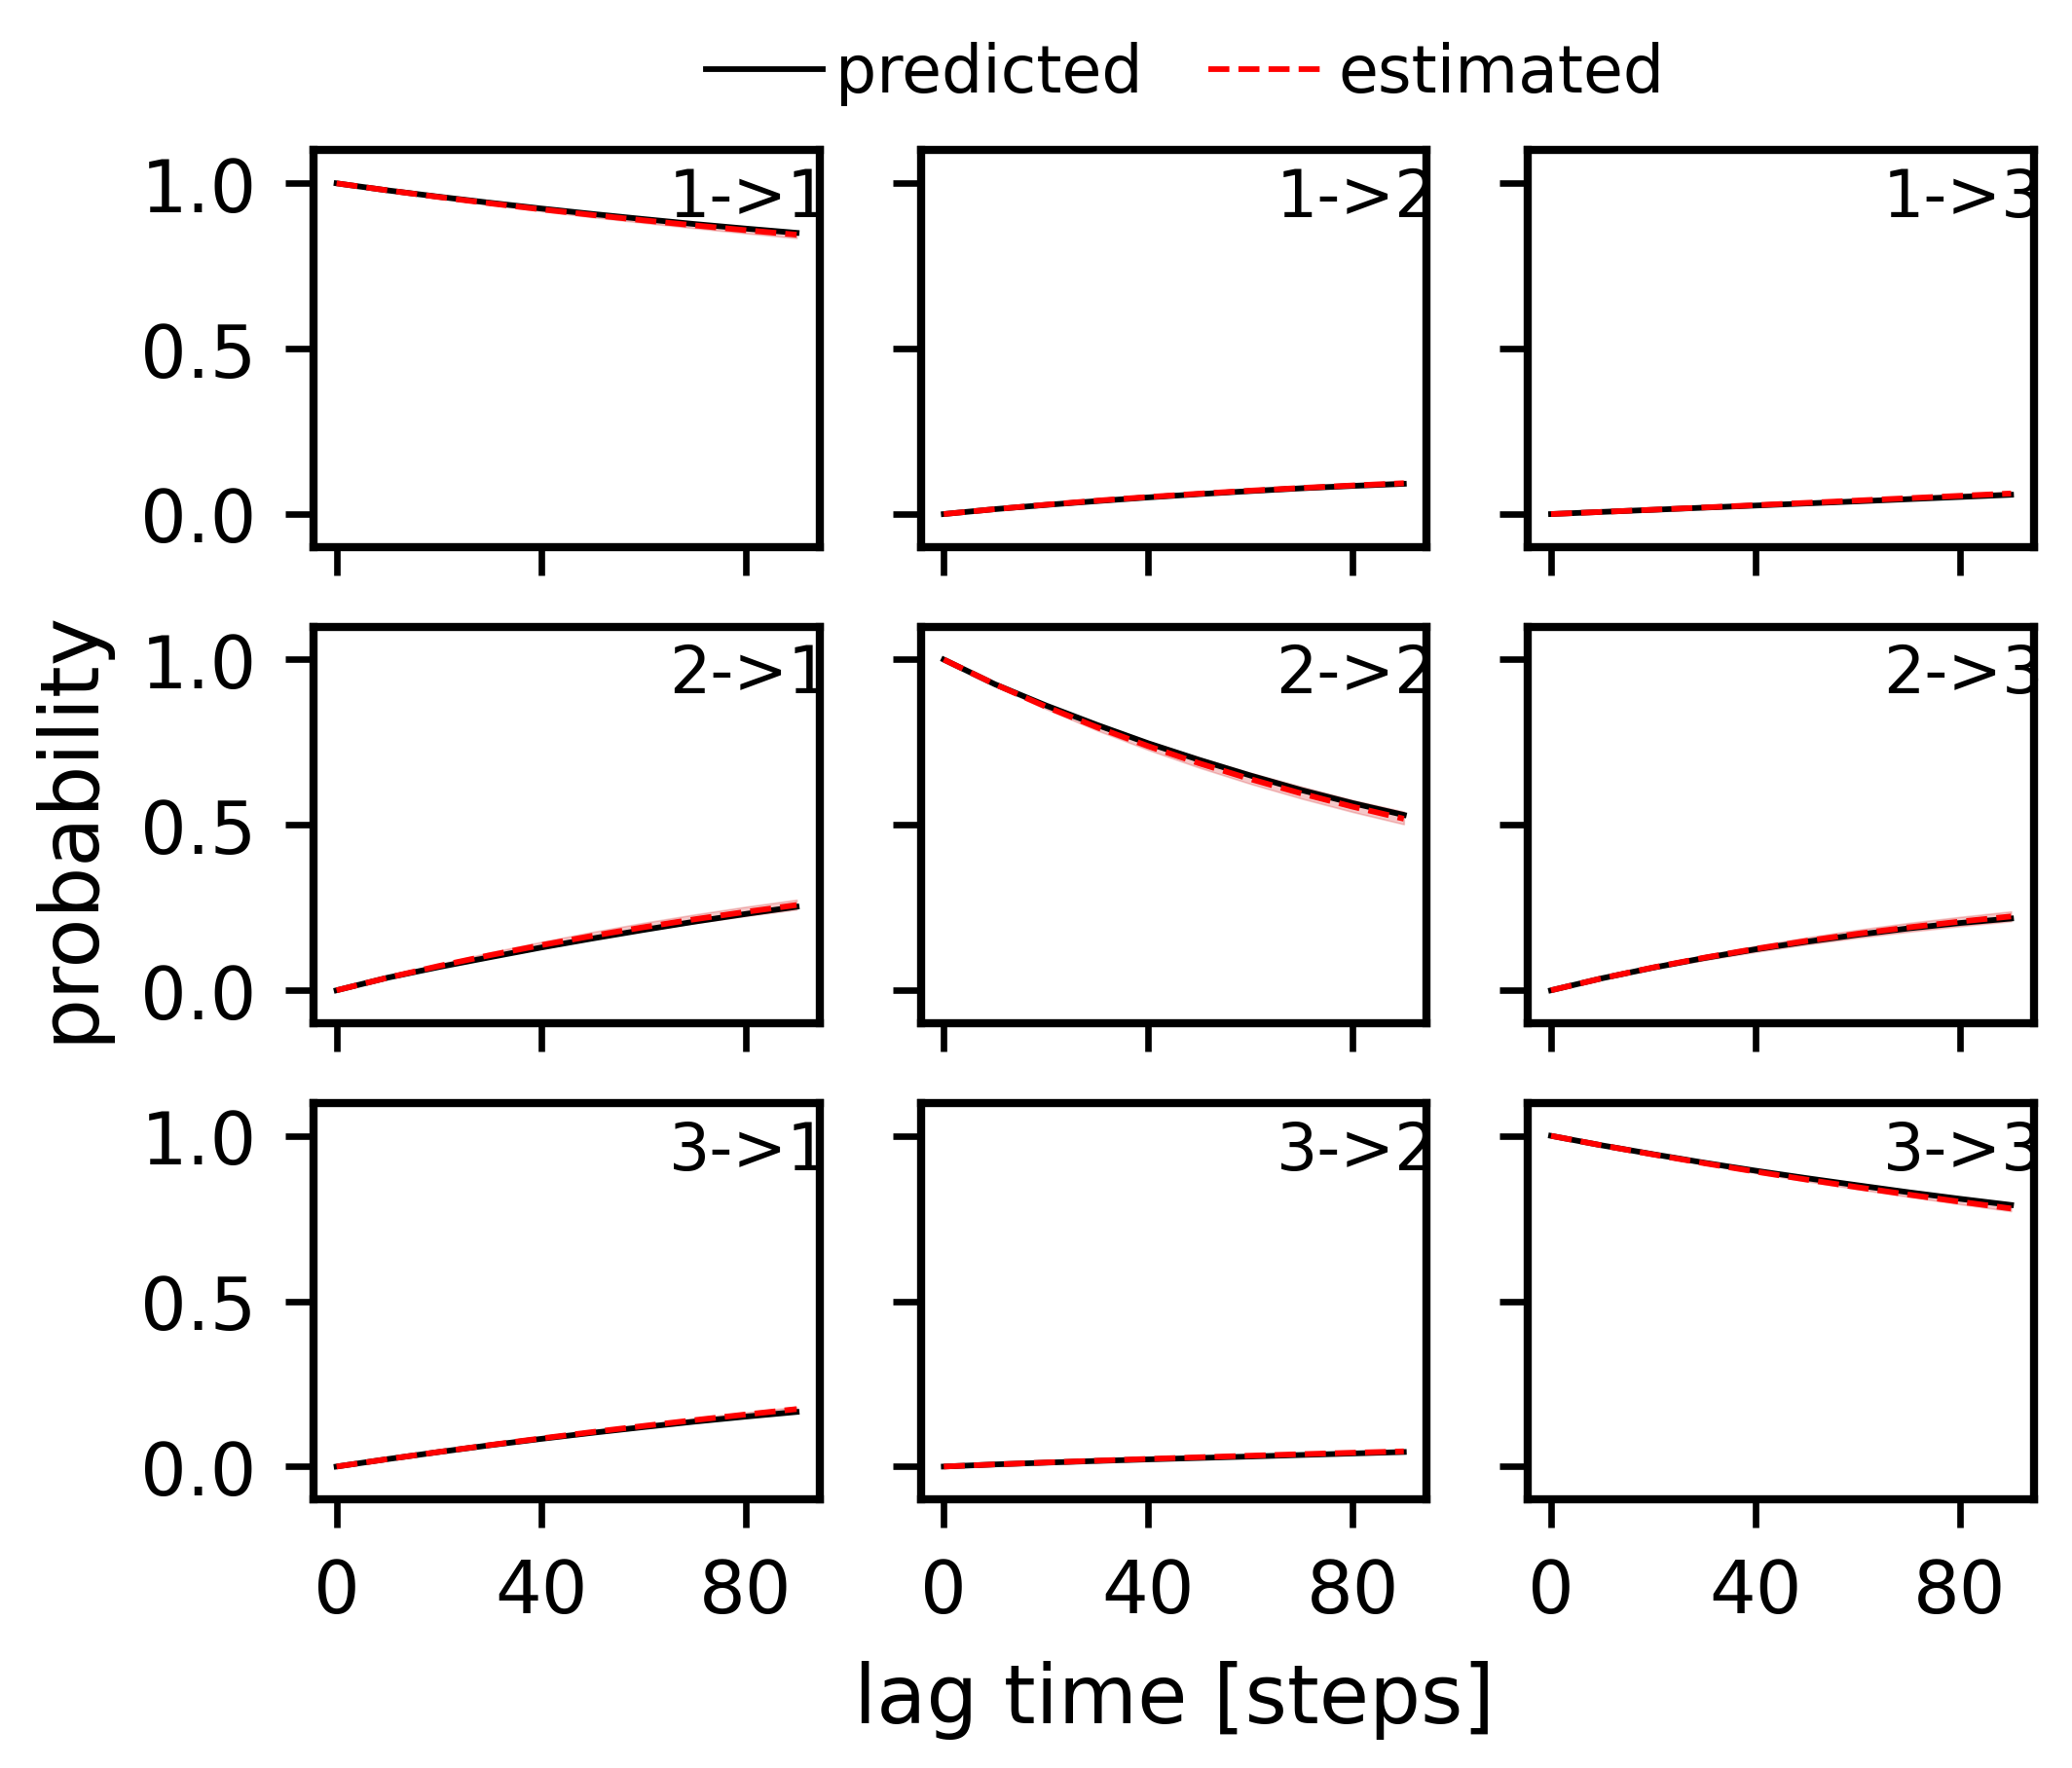

In [83]:
fig, ax = plt.subplots(3,3, figsize=(3.8,3), sharex=True, sharey=True)
type(ax)
pred_conf_low = ck3.predictions_conf[0]
pred_conf_up = ck3.predictions_conf[1]
x = ck3.lagtimes

plt.yticks([0.0,0.5,1.0],[0.0,0.5,1.0])
plt.xticks([0,40,80],[0,40,80])
plt.rc('axes', titlesize=8)
plt.rc('axes', labelsize=10)
plt.rc('xtick', labelsize=9)
plt.rc('ytick', labelsize=9)

for i in range(3):
    for j in range(3):
        ax[i,j].plot(x, ck3.estimates[:,i,j], 'k', linewidth=0.7, label='predicted')
        ax[i,j].plot(x, ck3.predictions[:,i,j], '--r', linewidth=0.7, label='estimated')
        ax[i,j].fill_between(x, pred_conf_low[:,i,j], pred_conf_up[:,i,j], alpha=0.25, color='tab:red', linewidth=0.2)
        ax[i,j].set_ylim(-0.1,1.1)
        ax[i,j].text(65,0.9, f'{i+1}->{j+1}', fontsize=8)

        if i==2 and j==1:
            ax[i,j].set_xlabel('lag time [steps]')
        if i==1 and j==0:
            ax[i,j].set_ylabel('probability')
            ax[i,j].legend(loc=(.75,2.28), ncols=2)

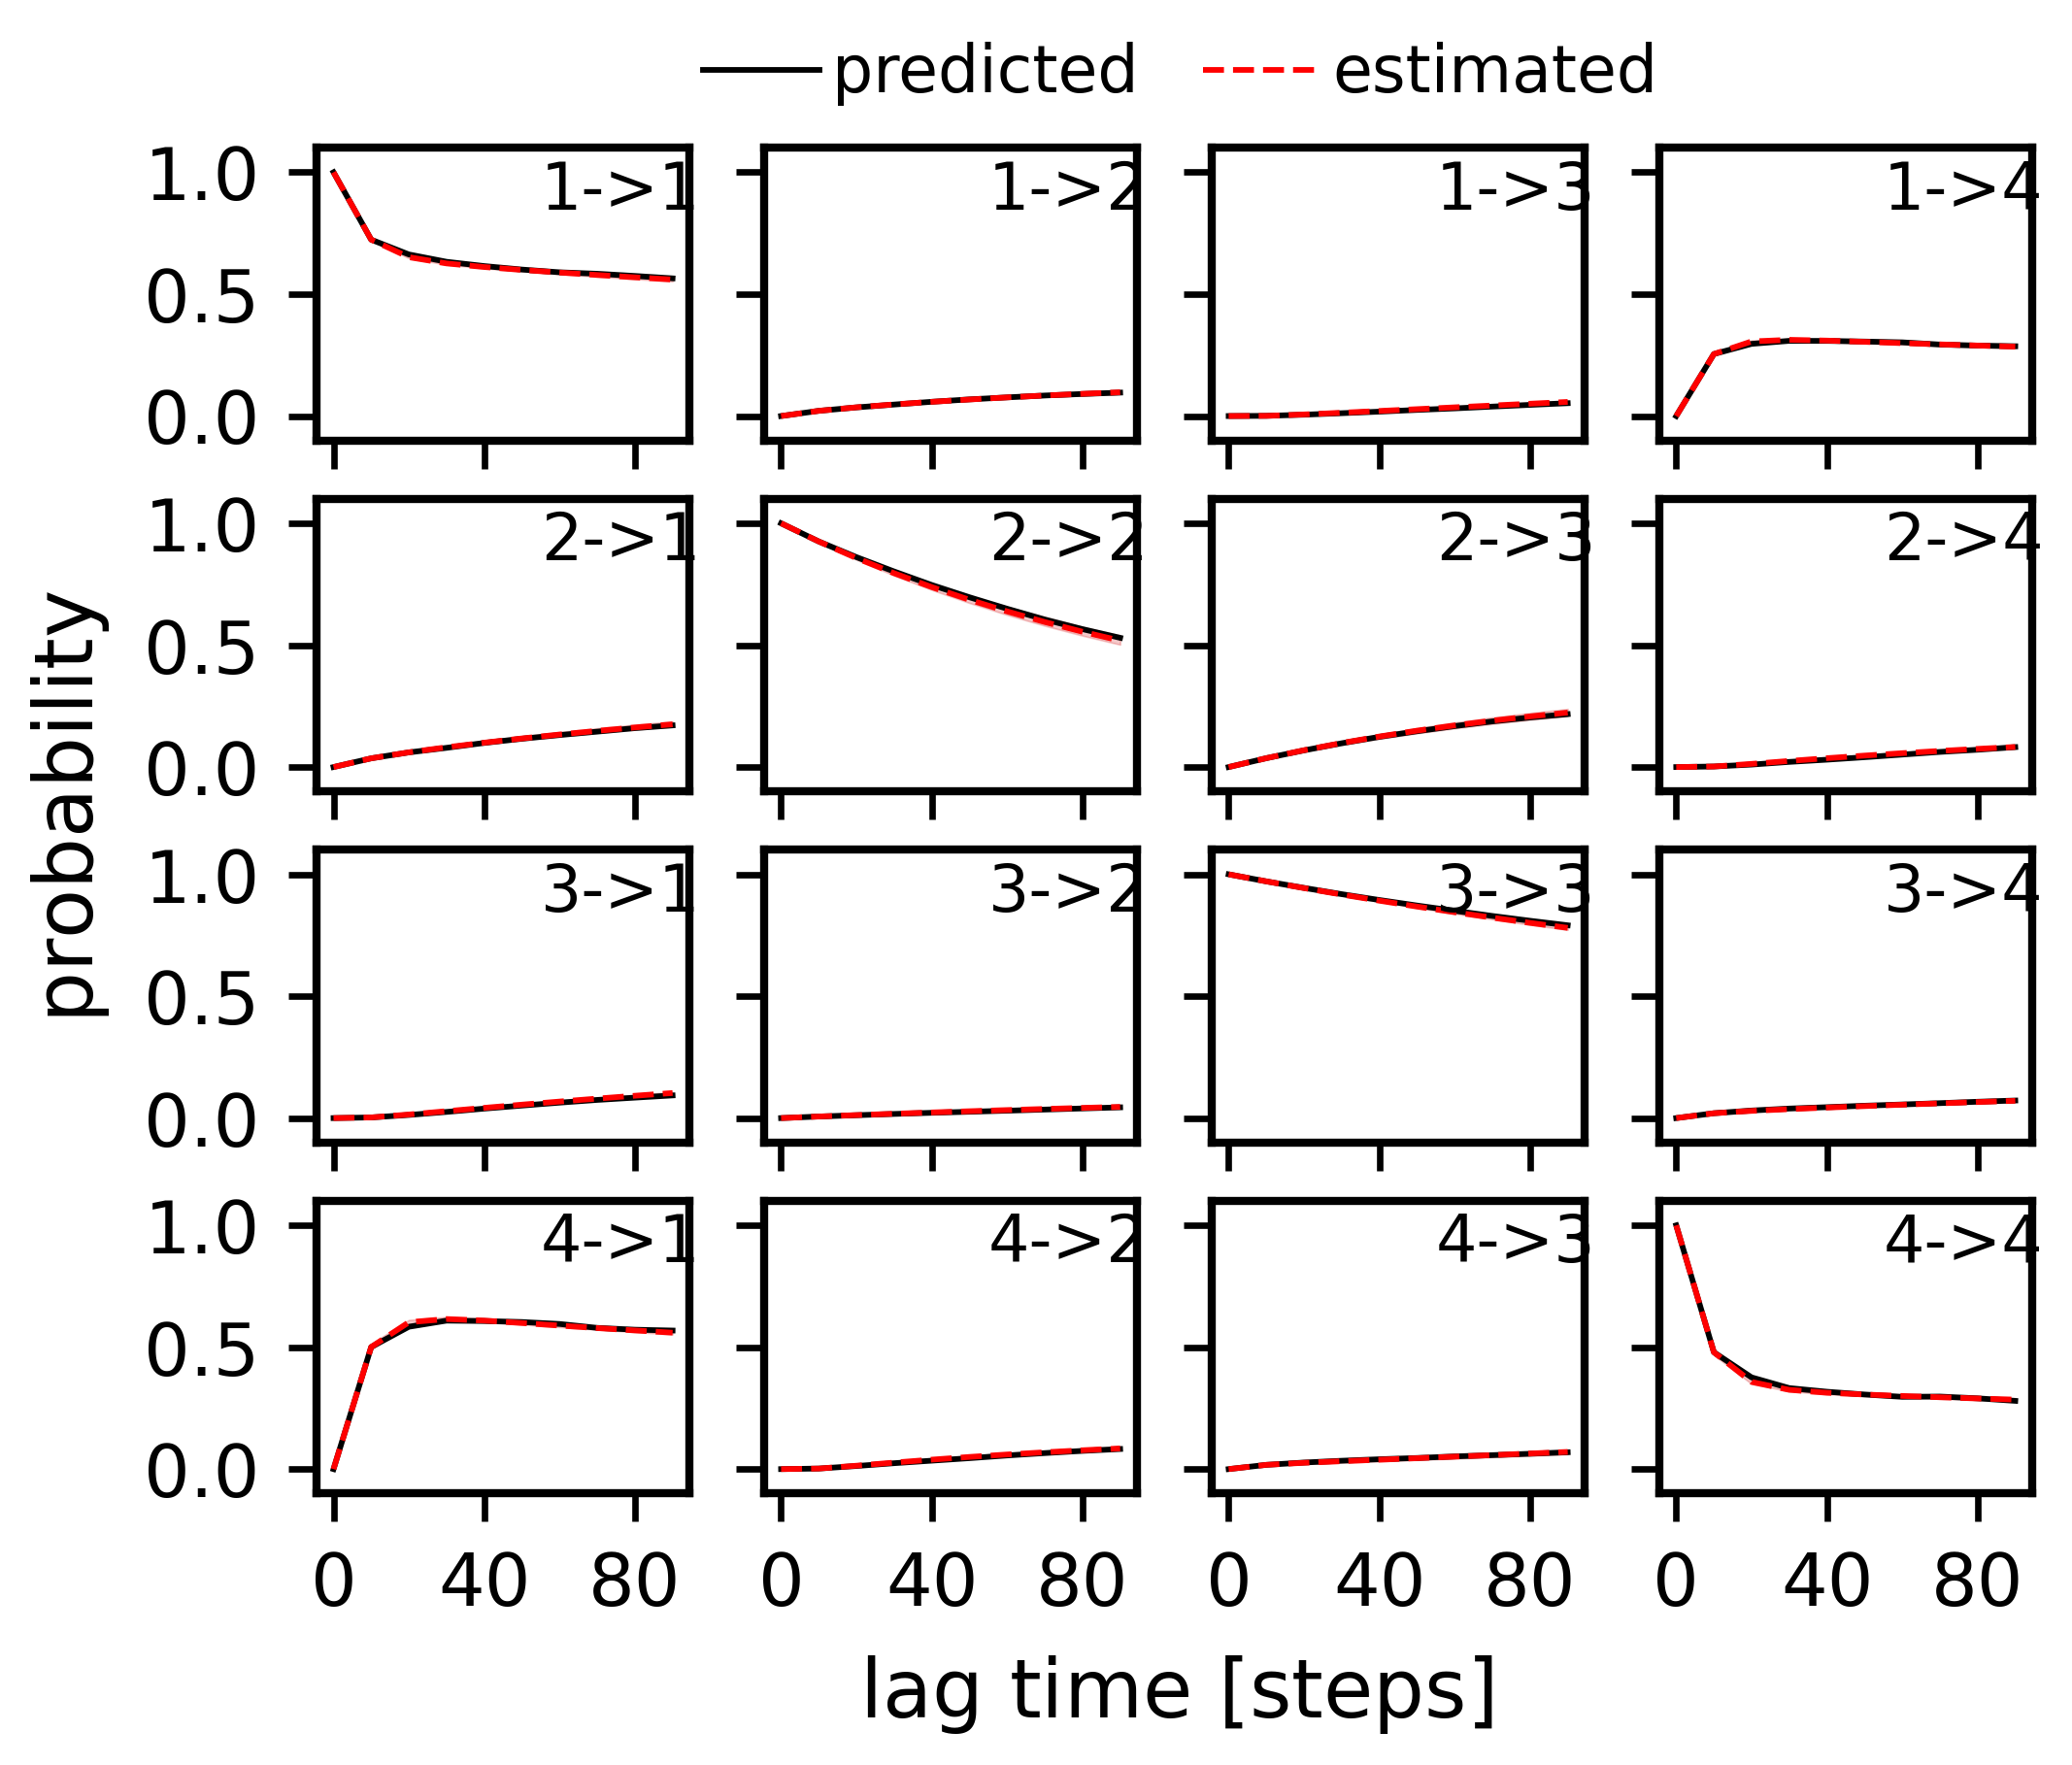

In [84]:
fig, ax = plt.subplots(4,4, figsize=(3.8,3), sharex=True, sharey=True)
type(ax)
pred_conf_low = ck4.predictions_conf[0]
pred_conf_up = ck4.predictions_conf[1]
x = ck3.lagtimes

plt.yticks([0.0,0.5,1.0],[0.0,0.5,1.0])
plt.xticks([0,40,80],[0,40,80])
plt.rc('axes', titlesize=8)
plt.rc('axes', labelsize=10)
plt.rc('xtick', labelsize=9)
plt.rc('ytick', labelsize=9)

for i in range(4):
    for j in range(4):
        ax[i,j].plot(x, ck4.estimates[:,i,j], 'k', linewidth=0.7, label='predicted')
        ax[i,j].plot(x, ck4.predictions[:,i,j], '--r', linewidth=0.7, label='estimated')
        ax[i,j].fill_between(x, pred_conf_low[:,i,j], pred_conf_up[:,i,j], alpha=0.25, color='tab:red', linewidth=0.2)
        ax[i,j].set_ylim(-0.1,1.1)
        ax[i,j].text(55,0.85, f'{i+1}->{j+1}', fontsize=8)

        if i==3 and j==1:
            ax[i,j].set_xlabel(r'$\qquad \qquad \qquad$ lag time [steps]')
        if i==2 and j==0:
            ax[i,j].set_ylabel(r'$\qquad \qquad \quad$ probability')
            ax[i,j].legend(loc=(1.,3.5), ncols=2)

### Compute transition matrix and Delta mu

In [91]:
def average(sample, n_term=0):
    ''' sample average 
        parameter n_term: first n_term data are discarded
        '''
    return (sample[n_term:]).sum()/(len(sample)-n_term)
    
def sigma_simple(sample, n_term=0):
    ''' sample standard deviation with zero covariance
        parameter n_term: first n_term data are discarded
        '''
    mu = average(sample, n_term)
    N = len(sample) - n_term
    return np.sqrt(((sample[n_term:] - mu)**2).sum()/(N*(N-1)))


def sigma_blocking(sample, pow_bin=0,  n_term=0):
    ''' sample standard deviation with covariance estimate with data blocking technique 
        parameter n_term: first n_term data are discarded
        parameter pow_bin: block size = 2^pow_bin
        '''
    dim_bin = 2**pow_bin
    n_bin = int(( len(sample[n_term:]) )/ dim_bin)    
    N = n_bin * dim_bin
    
    mu = average(sample[n_term:n_term+N])
    sample_split = np.array_split(sample[n_term:n_term+N],n_bin)
    sum_block = (np.array([ ( average(sample[n_term+i*dim_bin : n_term+(i+1)*dim_bin]) - mu )**2 for i in range(n_bin) ]) ).sum()
    
    return np.sqrt(sum_block)*dim_bin/N

def autocorr_bin(sample, pow_bin_max=10, n_term=0):
    ''' plot of sigma_blocking for different pow_bin:
            correlation lenght estimate
            '''
    pow_bin = [x for x in range(pow_bin_max)]
    sigma = np.array([sigma_blocking(sample, x, n_term) for x in pow_bin])
    sigma = sigma/sigma[0]
    plt.figure(10)
    #plt.yscale('log')
    plt.grid(True)
    plt.plot(pow_bin, sigma)
    plt.xlabel('log$_{10}$ correlation block size')
    plt.ylabel('error estimate with blocking')
    plt.show()

In [92]:
def dmu_estimate(dtraj, lag=1, kT=3*0.831446, n_term=0):
    msm = pyemma.msm.bayesian_markov_model(dtraj, lag=lag, reversible=False)
    t_matrix = msm.transition_matrix
    matrix_size = len(t_matrix)
    cycle = t_matrix[matrix_size-1,0]
    anti_cycle = t_matrix[0,matrix_size-1]
    for i in range(matrix_size-1):
        cycle *= t_matrix[i,i+1]
        anti_cycle *= t_matrix[i+1,i]
    return kT*np.log(cycle/anti_cycle)

def bootstrap_dmu_estimate(dtraj, lag=1, pow_bin=0, n_resample=100, n_term=0):
    dim_bin = int(2**pow_bin)
    n_bin = int(( len(dtraj)-n_term )/ dim_bin)    
    N = n_bin * dim_bin
    dtraj_list = np.reshape( dtraj[n_term: n_term+N], (n_bin, dim_bin) )
    
    rnd_matrix = np.random.randint(n_bin, size=(n_resample,n_bin))

    dtraj_resample = np.array([ np.reshape( np.array([ dtraj_list[i] for i in rnd_matrix[k] ]), N ) for k in range(n_resample) ])
    
    mu = np.array([ dmu_estimate(dtraj_resample[i], lag=lag) for i in range(n_resample) ])
    
    return np.sqrt(((mu - average(mu))**2).sum()/n_resample)

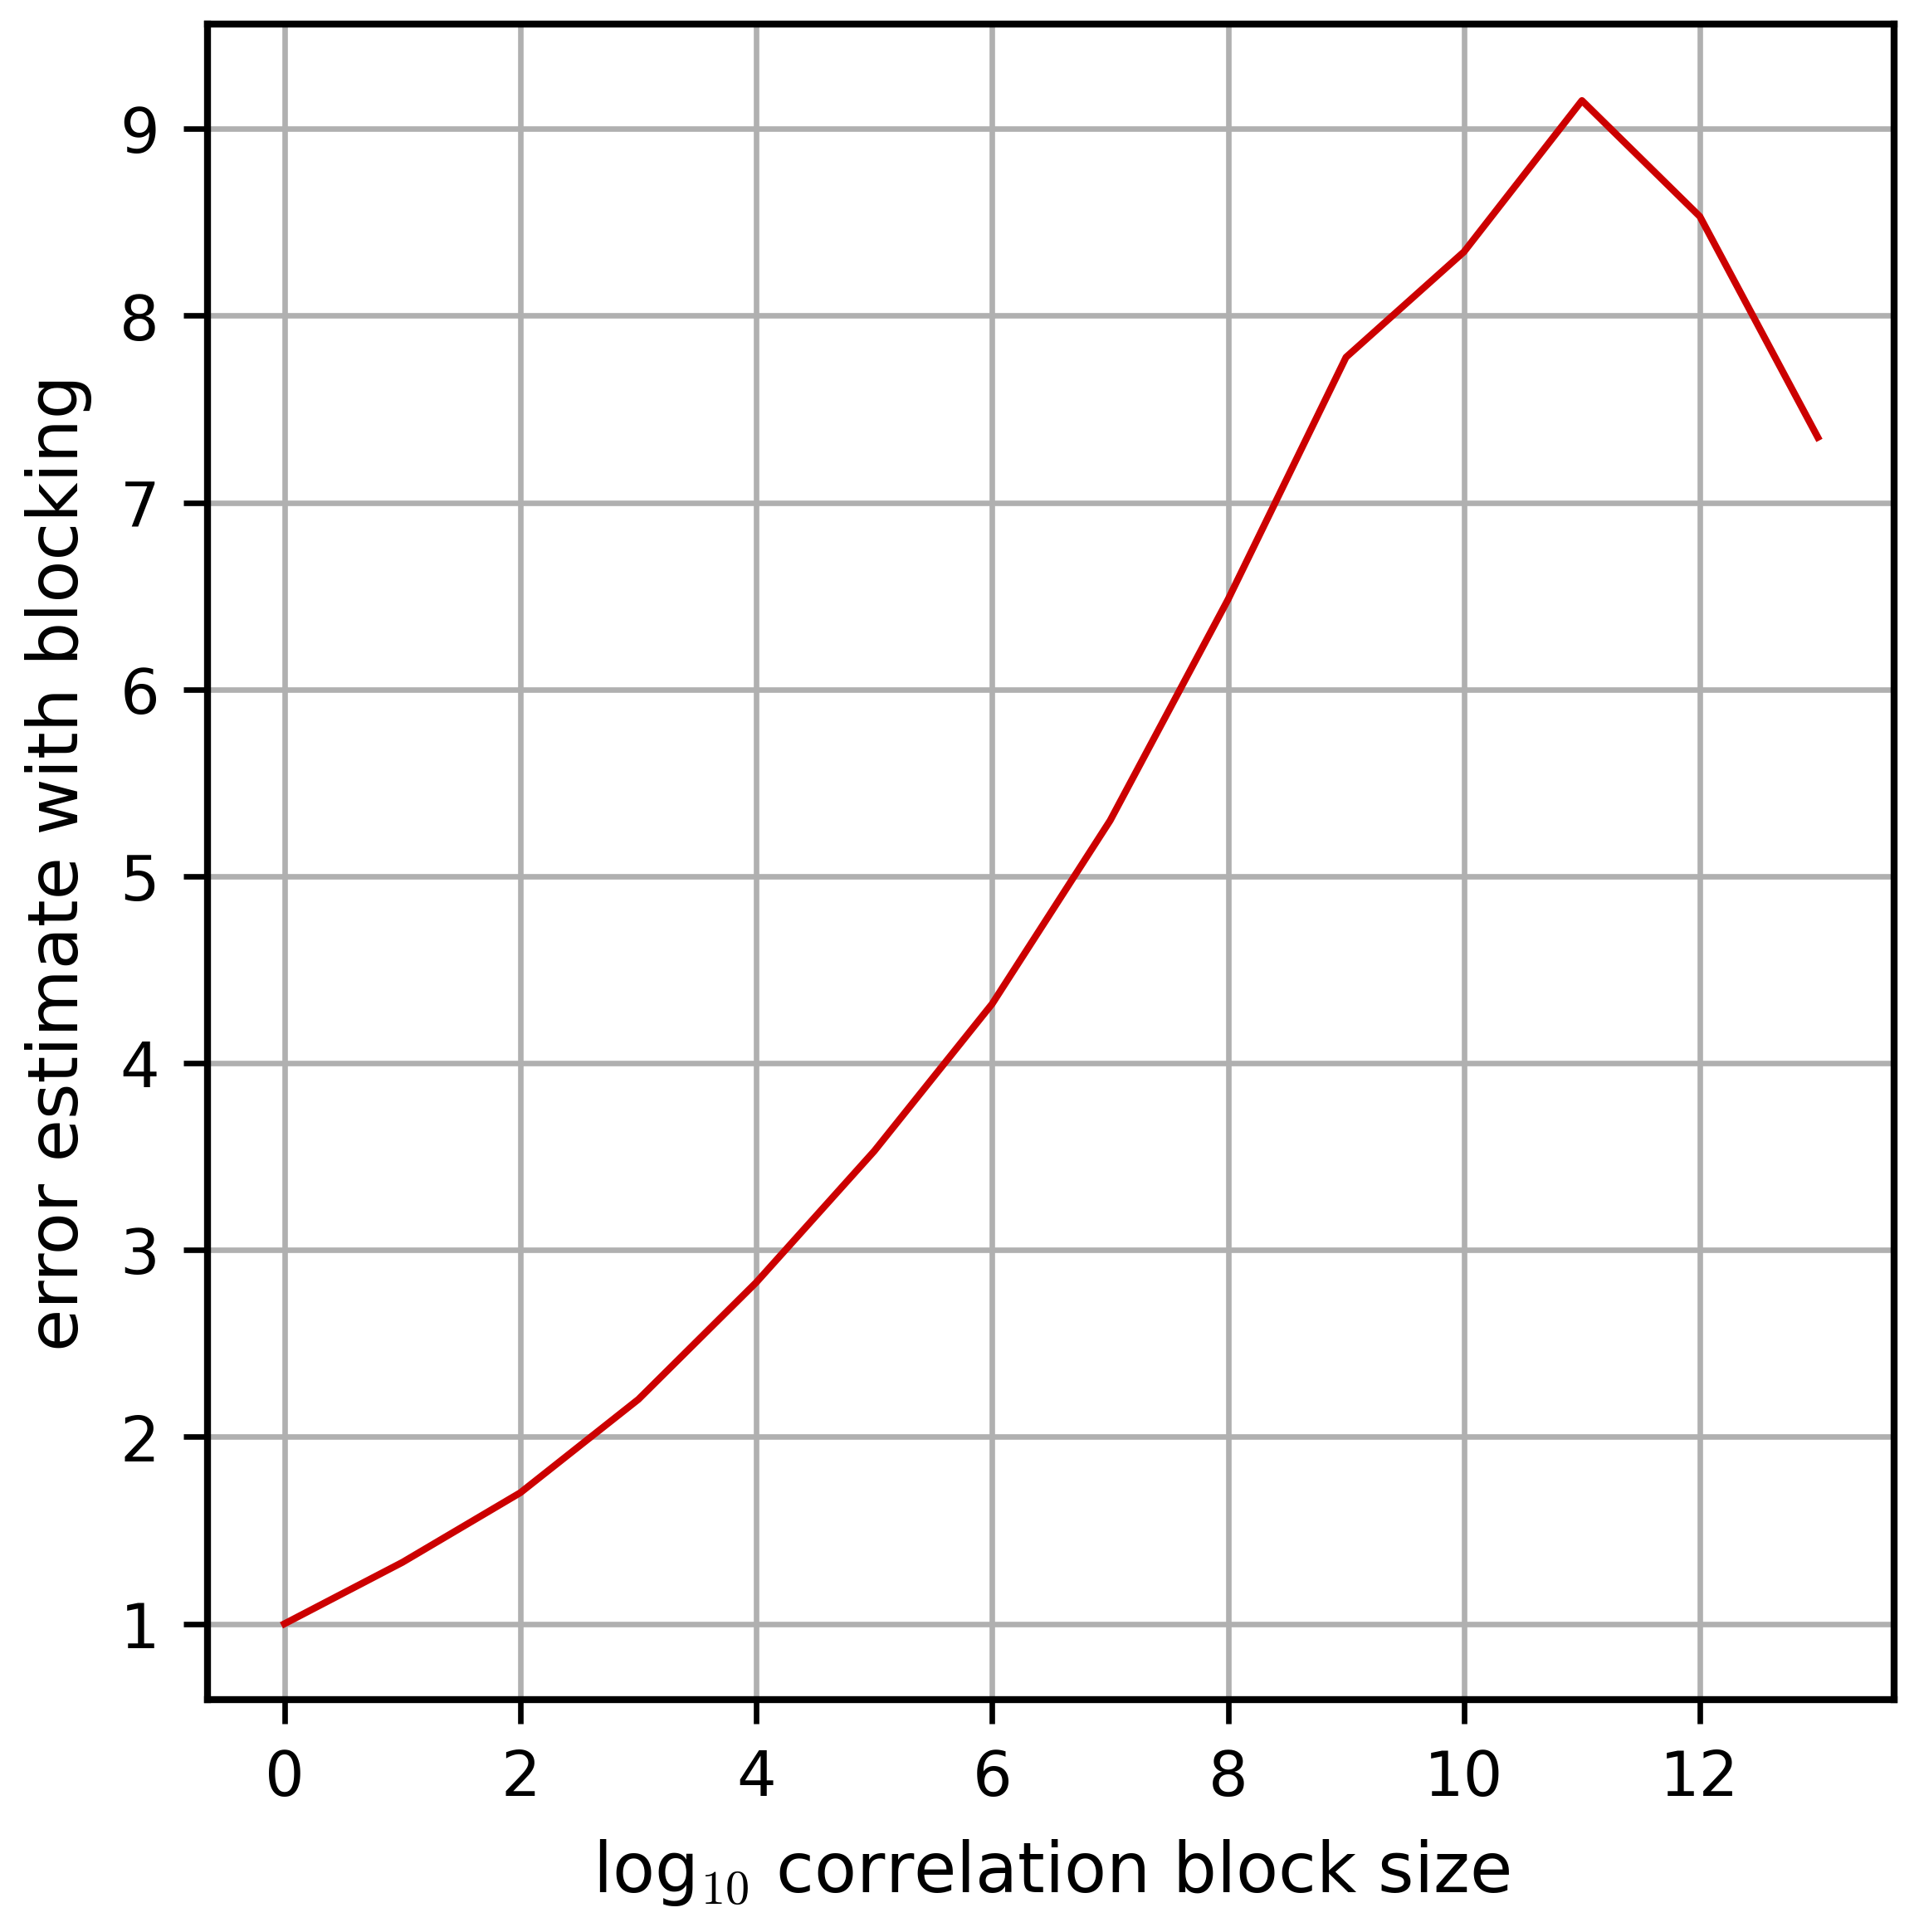

In [93]:
autocorr_bin(states, 14, 1000)

In [96]:
dmu = dmu_estimate(states, lag=10, n_term=1000)
sigma_dmu = bootstrap_dmu_estimate(states, lag=10, pow_bin=10, n_resample=30, n_term=1000)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1188.12it/s]


In [97]:
print(dmu, sigma_dmu)

5.037130116802774 0.6494182388551595


Estimate with 3-states MSM

In [98]:
states3 = np.copy(states)
states3[np.where(states3==4)] = 1

dmu = dmu_estimate(states3, lag=10, n_term=1000)
sigma_dmu = bootstrap_dmu_estimate(states3, lag=10, pow_bin=10, n_resample=30, n_term=1000)
print(dmu, sigma_dmu)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1188.59it/s]

5.0583491589032885 0.4774151299959109


### Comparison Delta mu estimated  and Delta mu expected

In [99]:
data = np.loadtxt('/localscratch/zippoema/md_data/simple-ness/single_ser_ness.txt')

In [100]:
def linear(x, a,b):
    return a*x + b

mux = data[:,1]
muy = data[:,2]
d_muy = data[:,3]

popt,pcov = curve_fit(linear, mux,muy)
err = np.sqrt(pcov.diagonal())
print(popt, err)

[0.9905     0.03861111] [0.02362514 0.15249955]


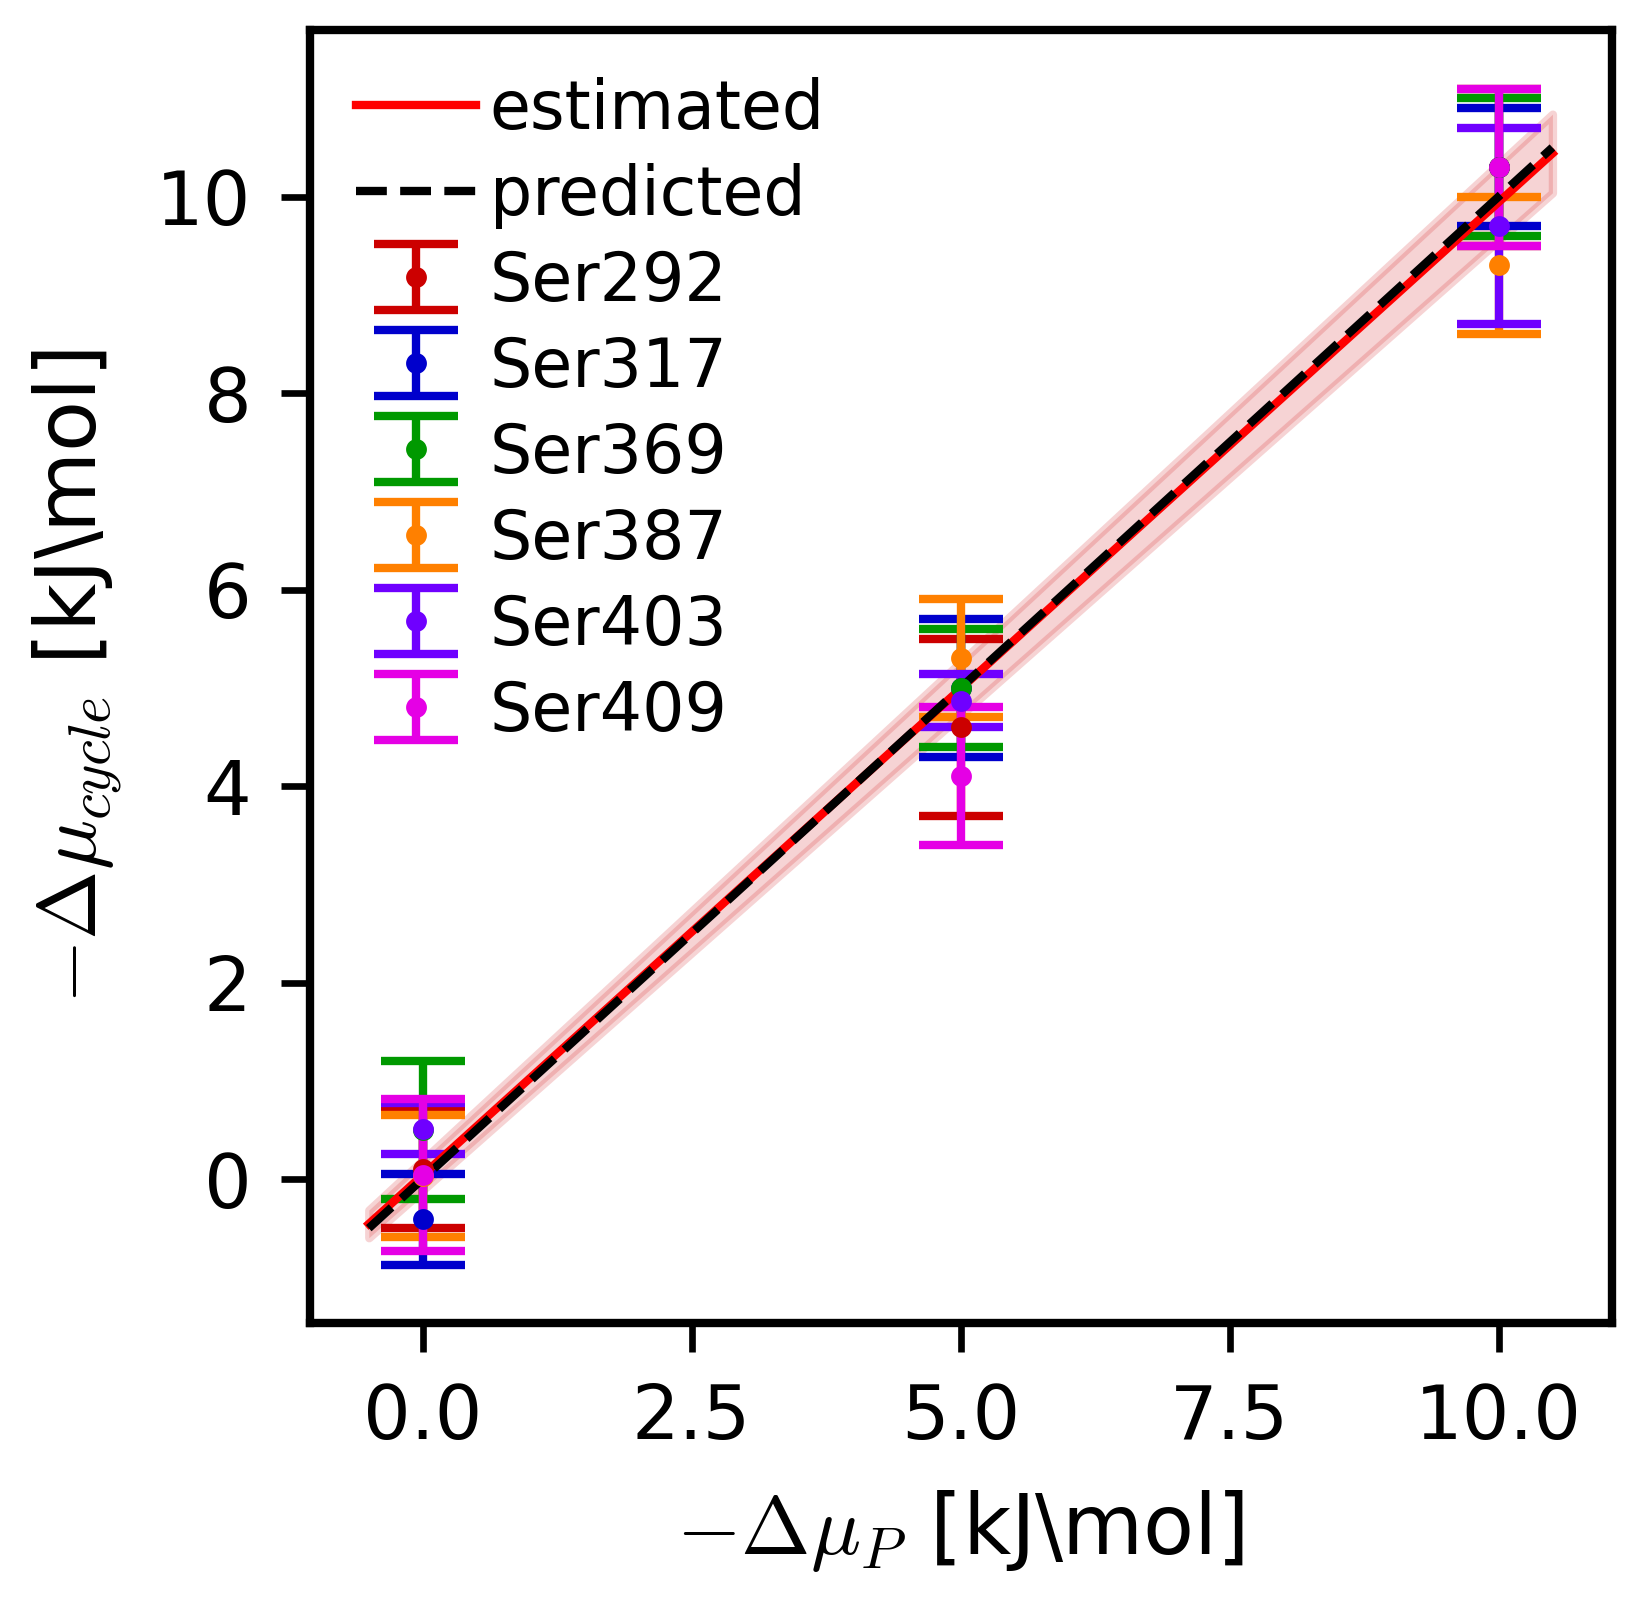

In [101]:
ser_l = [292,317,369,387,403,409]
x = np.array([-0.5,10.5])
y = linear(x, *popt)

plt.figure(figsize=(2.8,2.8))
for i,s in enumerate([2,4,10,15,19,22]):
    plt.errorbar(data[np.where(data[:,0]==s)][:,1], data[np.where(data[:,0]==s)][:,2], data[np.where(data[:,0]==s)][:,3], fmt='.', capsize=5, label=f'Ser{ser_l[i]}')

plt.plot(x, y, '-r', label='estimated')
plt.fill_between(x, y-err[1]-err[0]*x, y+err[1]+err[0]*x, alpha=0.2, color='tab:red')
plt.plot(x, x, '--k',  label='predicted')
plt.legend()
plt.xlabel('$- \Delta \mu_P$ [kJ\mol]')
plt.ylabel('$- \Delta \mu_{cycle}$ [kJ\mol]')
plt.show()